Ce notebook à pour but de créer un algorithme de Q leaning dans le contexte de vente et d'achat d'action. 
L'algorithme peut utiliser plusieurs cours d'actions de différentes entreprises en même temps
Afin de rendre l'algorithme plus facile, la quantité d'action et leur prix sont discrétisé pour la matrice Q des actions possibles
C'est à dire que l"on va séparer les valeurs en quantile, par exemple si l'on utilise 5 quantile alors on peut avoir 0%,20%,40%,... des données et on les actions peuvent être au dessus de 0%,20%,40% de leur valeur maximale.
Pour des soucis d'implémentation on oblige le nombre de quantile sur le prix des actions et la quantité d'action à être identique.

Pour plus de précision sur le système de discrétisation. 
Par la suite on appellera indifférement n_quantile ou n_nuance le nombre de palier de notre différentiation. 
Par exemple avec n_quantile = k alors on peut avoir 0%, (1/k)%, (2/k)%,(k-1/k)%,100% action de l'entreprise que l'on notera 0,1,2,...,k actions. 
Et toujours avec n_quantile = k alors les actions peuvent valoir 0%, (1/k)%, (2/k)%,(k-1/k)%,100% de leur variable maximale, toujours noté 0,1,2,...,k

Attention augmenter le nombre d'actions considérées et de quantile augmente exponentiellement la taille de la matrice Q. 
Nous avons donc utiliser l'algorithme seulement sur 2 cours d'actions sinon nous dépassons les capacités de nos ordinateurs

In [27]:
from numpy.random import default_rng

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform

In [28]:
# La matrice Q est la matrice qui contient nos probabilité de transitions d'un êtat présent à un êtat futur
# L'indice de la ligne correspond à l'êtat présent du système tandis que la colonne indique le futur êtat si l'action est prise 
# Si l'on note n_quantile le nombre de quantile possible ie le nombre de nuance que l'on donne 
# La relation entre les indices et les êtats qu'ils représentent ressemblent à un changement de base 
def initQ3(state0,n_quantile):
    
   
    n_action = int((len(state0) - 1)/2)
    n_action = int(n_action*2)
    Q = default_rng(70).random(((n_quantile + 1 )**n_action,((n_quantile + 1 )**n_action)))
    
    return Q   

In [29]:
Q = initQ3([0,0,0,0,0,0,1000],4)
len(Q)

15625

In [30]:
def state_to_indice2(state,n_action,n_quantile):
    # On prend un êtat et on son indice dans la matrice Q 
    # L'idée de cette fonction est que l'on passe d'un base n_quantile + 1(l'êtat) à une base 1(l'indice) 
    indice = 0 
    for k in range(n_action*2):
        indice += state[k] * (n_quantile + 1)**k
    return int(indice)

In [31]:
def indice_to_action2(indice,n_action,n_quantile):
    # On prend une place dans la matrice Q  et on retourne l'êtat correspondant 
    # L'idée de cette fonction est que l'on passe d'un base 1 à une base   n_quantile + 1
    action = []
    for k in range((n_action)*2 - 1,-1,-1):
        terme = indice // (n_quantile+1)**(k)
        action.insert(0,terme)
        indice = indice - terme * (n_quantile+1)**k
    return(action)


In [32]:
def action_possible2(state,action,budget,true_state):
    # On vérifie si notre transiction de notre êtat actuel à l'êtat suivant est possible
    # ie on vérifie si on peut acheter les actions avec notre budget que l'on avait 
    possible = False
    depense = 0 
    n_action = int((len(state) - 1)/2)
    

    for k in range(n_action):
        depense =  depense + (action[k] - state[k])*true_state[k]
    if budget >= depense:
        possible = True
    return(possible) 

In [33]:
def choix_action3(state,Q,valeurs,n_quantile,true_state):
    # On choisit l'action selon la valeur de la matrice Q à a la ligne de l'êtat présent
    # On ajoute un facteur aléatoire d'une loi uniforme afin de ne pas rester bloqué dans une boucle lors de l'apprentissage
    new_state = [0]*len(state)
    n_action = int((len(state) - 1)/2)
    new_state[n_action:] = valeurs
    budget = state[-1]
    j = 0
    # On récupère l'indice de la ligne de l'êtat présent
    s = state_to_indice2(state,n_action,n_quantile)
    max = -10
    for i in range((n_quantile+1)**n_action):
        action = indice_to_action2(i,n_action,n_quantile)
        possible = action_possible2(state,action,budget,true_state)
        # Le facteur a va servir à rajouter de l'aléatoire au choix de l'action suivante afin de ne pas rester bloqué sur un êtat 
        a = uniform(0,1)
        
        if a*Q[s][i] >= max and possible == True: 
            if action[n_action:] == valeurs:
                j = i
                max=Q[s][i]
                new_state[0:n_action] = action
    return new_state, j

In [34]:
def reward2(new_state,state,n_action,true_state):
    # Calcul de la récompense c'est à dire notre argent après les transactions
    # On part du budget
    R = true_state[-1]
    for k in range(n_action):
        # On ajoute ce que l'on a avec nos actions présentes moins ce que l'on aurait eu en gardant les actions précédentes 
        R += new_state[k]*true_state[k] - state[k]*true_state[k] 
    return(R/state[-1])

In [35]:
def diff2(state,new_state,Q,a,n_quantile):
    # Calcul d'un terme de changement de la matrice Q 
    n_action = int((len(state) - 1)/2)
    indice1 = state_to_indice2(state,n_action,n_quantile)
    max = -10
    c = Q[indice1][a]
    for i in range(((n_quantile + 1 ))**n_action):
        if Q[indice1][i] - c >= max:
            max = Q[int(indice1)][i]-c
    return max

In [36]:
def make_new_state2(new_state,state,n_action,true_data,k):
    # Créé le nouvel êtat à partir de l'action choisit
    # ie on va calculer l'augmentation de notre budget en retirant la quantité d'action acheté par leur prix
    budget2 = state[-1]
    for i in range(n_action):
        budget2 = budget2 + (state[i] - new_state[i])*true_data[k][i]
    new_state.append(budget2)
    return(new_state)

In [37]:
def qlearning3(state0, data, alpha, gamma,n_quantile,true_data): # alpha : pas de l'algorithme; gamma : hyperparamètre
    # data les données en quantiles 
    # true_data contient les données avant la transformation en quantile sert nottament à calculer notre budget
    Q = initQ3(state0,n_quantile)
    n_action = int((len(state0) - 1)/2)
    state = state0
    liste_state = []
    # boucle sur l'ensemble des données pour l'apprentissage 
    for k in range(1,len(data)):
        #On choisit le nouvel êtat en se basant sur la matrice Q
        true_state = true_data[k] 
        new_state = choix_action3(state,Q,data[k],n_quantile,true_state)[0]
        new_state[n_action:] = data[k]
        # On calcule l'indice du nouvel êtat/action
        indice_action = choix_action3(state,Q,data[k],n_quantile,true_state)[1]

        # étape d'update de la matrice Q
        R = reward2(new_state,state,n_action,true_state) # ce qu'on a perdu ou gagné à l'étape (reward)

        difference = diff2(state,new_state,Q,indice_action,n_quantile)

        indice1 = state_to_indice2(state,n_action,n_quantile)
        Q[indice1][indice_action] += alpha*(R+gamma*difference)
        # On termine de créer le nouvel êtat du système 
        state = make_new_state2(new_state,state,n_action,true_data,k)
        # On ajoute l'êtat à la trajectoire
        liste_state.append(state)
    return Q, liste_state

In [38]:
# On test l'algorithme de Q learning 
stocks = pd.read_csv('all_stocks_5yr.csv')


In [39]:
stocks = stocks.drop(['date', 'open', 'high', 'low', 'volume'], axis=1) 
stocks

,close,Name
0,14.75,AAL
1,14.46,AAL
2,14.27,AAL
3,14.66,AAL
4,13.99,AAL
...,...,...
619035,77.82,ZTS
619036,76.78,ZTS
619037,73.83,ZTS
619038,73.27,ZTS


In [40]:
stocks.iloc[100000]

close    30.82
Name       CBG
Name: 100000, dtype: object

In [58]:
stocksAAL = stocks.loc[stocks['Name'] == "AAL"]
stocksAAL = stocksAAL["close"].values.tolist()
stocksZTS = stocks.loc[stocks['Name'] == "ZTS"]
stocksZTS = stocksZTS["close"].values.tolist()

data = []
for k in range(len(stocksAAL)): 
    data.append([stocksAAL[k],stocksZTS[k]])

On applique une transformation au données pour les transformer en 1,2,...,n_quantile

In [42]:
def data_to_limite_quantile(data,n_quantile):
    # Détermine les quantiles d'ordre n_quantile% du jeu de données 
    # Retourne une liste de taille n_action*n_quantile
    seq_quantile = [1]
    limite = []
    for j in range(1,n_quantile + 1):
        seq_quantile.append(1 - j/(n_quantile))
    data_bis = []
    for n in range(len(data[1])): 
        data_bis.append([])
    for d in data: 
        for i in range(len(d)):
            data_bis[i].append(d[i])

    for d in data_bis:
        limite.append(list((np.quantile(d,seq_quantile))))
    return limite

In [43]:
def data_to_quantile(data,limite_quantile):
    #Transforme notre jeux de données en les quantiles associé
    n_quantile = len(limite_quantile[0]) - 1
    new_data = []
    for j in range(len(data)):
        new_data.append([])
        for i in range(len(data[0])):
            new_data[j].append(-10)
    for k in range(len(data)):
        quantile = 0
        quantiles = []
        dk = data[k]
        for j in range(len(dk)):
            d = dk[j]
            for i in range(n_quantile - 1):
                if d <= limite_quantile[j][i] and d >= limite_quantile[j][i +1]:
                    quantile = n_quantile - i
            quantiles.append(quantile)
        new_data[k] = quantiles
    return(new_data)

In [44]:
# Limite est une liste contenant les quantile d'ordre n_quantile 
limite = data_to_limite_quantile(data,10)
print(limite)

[[58.47, 50.442, 47.84, 45.199999999999996, 42.668, 40.87, 38.802, 36.05800000000001, 30.02, 18.116, 13.02], [80.09, 62.676, 53.512, 49.99, 47.327999999999996, 45.62, 42.776, 34.212, 32.316, 30.92, 28.4]]


In [45]:
# On va créer un nouveau jeu de données qui contient les quantiles plutôt que les valeurs brut 
new_data = data_to_quantile(data,limite)


In [46]:
state0 = [0,0,2,2,200]
Q,trajectoire = qlearning3(state0,new_data, 0.05, 0.05,10,data)


In [ ]:
n_action = (int((len(trajectoire[0]) -1)/2))
qt = []
color = ['b','g','r','c','m','y','k','w']
for i in range(n_action):
    qt.append([])
for k in range(len(trajectoire)):
    for i in range(n_action):
        qt[i].append(trajectoire[k][i])
for i in range(n_action):
    plt.plot(qt[i],color[i])

In [ ]:
plt.plot(qt[1],'bo')

In [ ]:
budget = []
for k in range(len(trajectoire)):
    budget.append(trajectoire[k][-1])
plt.plot(budget)

On peut utiliser l'algorithme avec plus de 2 actions en même temps 


On observe que notre algorithme à une forte tendance à se bloquer dans un êtat, cela peut être du au fait que les évolutions entre deux instants 
sont négligeable par rapport au variation au cours du temps. 
On va donc calculer une tendance linéaire et la retirer des données pour ne garder que des tendances pas à pas qui devrait plus varier entre 2 pas 

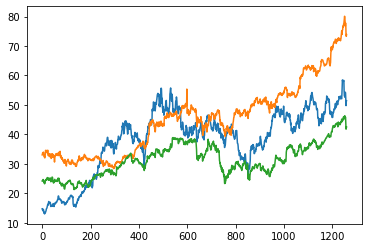

In [51]:
# On observe une croissance linéaire nottament sur la courbe orange, il est donc cohérent de chercher à retirer cette tendance 
plt.plot(data)


In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
modele1 = LinearRegression(fit_intercept=True)
modele2 = LinearRegression(fit_intercept=True)


In [61]:
x = [*range(len(data))]

In [62]:
data1 = []
data2 = []
for i in range(len(data)):
    data1.append(data[i][0])
    data2.append(data[i][1])

In [64]:
#On utilise une régréssion linéaire sur chaque jeux d'actions pour calculer la tendance linéaire au cours du temps
modele1 = LinearRegression(fit_intercept=True)
modele2 = LinearRegression(fit_intercept=True)
df1 = pd.DataFrame (data1, columns = ['data1'])
df2 = pd.DataFrame (data1, columns = ['data1'])
dfx = pd.DataFrame(x,columns = ["x"]) 
modele1.fit(X = dfx, y = df1)
modele2.fit(X = dfx, y = df2)

LinearRegression()

In [66]:
pred1 = modele1.predict(dfx)
pred2 = modele1.predict(dfx)

In [67]:
# On enlève la tendance linéaire aux données de base
data_regressed = []
for k in range(len(data1)):
    data_regressed.append([(data1[k] - pred1[k]).item(),(data2[k] - pred2[k]).item()])

In [68]:
# On va maintenant passer les données en quantile pour être utilisable par notre algorithme 
# On utilise la fonction data to limite définit précédement
limite = data_to_limite_quantile(data_regressed,10)

print(limite)

[[20.320580650131376, 10.93450223971718, 5.927163862787374, 3.7033219210480057, 1.5327597735074951, 0.08048418390390566, -2.0870121670081843, -4.860594184371126, -7.713240226492505, -9.46035363751855, -18.02318589049599], [27.990176645129857, 13.463611488287132, 10.322036023966378, 8.506212138040283, 7.233770080985532, 6.145671139893601, 4.834886417035443, 3.504118062398908, 2.3828255279967423, 0.22137316346395694, -2.62128005041572]]


In [69]:
def data_to_quantile_regressed(data,limite_quantile):
    n_quantile = len(limite_quantile[0]) - 1
    new_data = []
    for j in range(len(data)):
        new_data.append([])
        for i in range(len(data[0])):
            new_data[j].append(-10)
    for k in range(len(data)):
        quantile = 0
        quantiles = []
        dk = data[k]
        for j in range(len(dk)):
            d = dk[j]
            for i in range(n_quantile - 1):
                if d <= limite_quantile[j][i] and d >= limite_quantile[j][i +1]:
                    quantile = n_quantile - i
            quantiles.append(quantile)
        new_data[k] = quantiles
    return(new_data)

In [70]:
new_data_regressed = data_to_quantile_regressed(data_regressed,limite)
print(new_data_regressed)
print((data_regressed))
# On bouge déja un peu plus sur les données d'entrées

[[0, 8], [0, 8], [0, 8], [0, 8], [0, 8], [0, 8], [0, 8], [0, 7], [0, 7], [0, 7], [0, 7], [0, 7], [0, 7], [0, 8], [0, 8], [0, 8], [0, 8], [0, 8], [0, 8], [0, 8], [0, 8], [0, 8], [2, 8], [2, 8], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [2, 7], [0, 7], [0, 6], [0, 6], [0, 6], [0, 7], [0, 7], [0, 7], [2, 7], [2, 7], [0, 6], [2, 7], [2, 7], [2, 6], [0, 6], [0, 6], [2, 5], [2, 5], [2, 5], [2, 6], [2, 6], [2, 7], [2, 7], [2, 7], [2, 7], [2, 6], [2, 6], [2, 7], [2, 7], [2, 7], [2, 6], [2, 6], [3, 6], [3, 7], [3, 7], [3, 7], [2, 6], [2, 7], [2, 6], [2, 7], [2, 7], [2, 6], [2, 5], [2, 5], [2, 6], [2, 6], [2, 5], [0, 5], [2, 5], [2, 5], [2, 5], [0, 5], [2, 4], [0, 4], [0, 4], [2, 4], [2, 4], [0, 4], [0, 4], [0, 4], [0, 5], [0, 4], [0, 4], [0, 4], [0, 4], [0, 3], [0, 3], [0, 3], [0, 4], [2, 4], [0, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 4], [2, 4], [2, 4], [2, 4],

In [71]:
# On lance l'algorithme de Q learning sur nos données avec la tendance en moins
state0 = [0,0,2,2,200]
Q,trajectoire_regressed = qlearning3(state0,new_data_regressed, 0.05, 0.05,10,data)

In [ ]:
n_action = (int((len(trajectoire_regressed[0]) -1)/2))
qt = []
color = ['b','g','r','c','m','y','k','w']
for i in range(n_action):
    qt.append([])
for k in range(len(trajectoire_regressed)):
    for i in range(n_action):
        qt[i].append(trajectoire_regressed[k][i])
for i in range(n_action):
    plt.plot(qt[i],color[i])

Dernière variation: 
Une utilisation des variations relatives des cours à la place des valeurs à l'instant t

In [74]:
# On va utiliser les variations relatives des données par rapport à la valeur précédentes à la place de la valeur absolue 
# Il nous faut créer un dataset avec les variations relatives à la valeur précédentes

In [75]:
data_variations = []
for i in range(1,len(data)):
    data_variations.append([(data[i][0] - data[i-1][0])/data[i-1][0],(data[i][1] - data[i-1][1])/data[i-1][1]])

In [76]:
limite_variation = data_to_limite_quantile(data_variations,10)


In [77]:
new_data_variation = data_to_quantile(data_variations,limite_variation)


In [78]:
state0 = [0,0,2,2,200]
Q,trajectoire_variation = qlearning3(state0,new_data_variation, 0.05, 0.05,10,data)

In [ ]:
trajectoire_variation

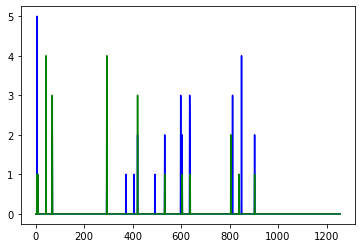

In [80]:
n_action = (int((len(trajectoire_variation[0]) -1)/2))
qt = []
color = ['b','g','r','c','m','y','k','w']
for i in range(n_action):
    qt.append([])
for k in range(len(trajectoire_variation)):
    for i in range(n_action):
        qt[i].append(trajectoire_variation[k][i])
for i in range(n_action):
    plt.plot(qt[i],color[i])